In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
import pydot
import graphviz
import tensorflow as tf
import tiffile as tif
from PIL import Image

2024-04-16 11:52:38.180031: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 11:52:43.707866: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 11:53:20.353965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(keras.__version__)
print(tf.__version__)

3.2.1
2.16.1


In [3]:
# Function that takes a tiff image and pads it to the desired size (square) and returns a numpy array
def pad_image(image, size):
    # load the image
    img = tif.imread(image)
    # get image dimensions
    x,y = img.shape
    # calculate the padding
    x_pad = size - x
    y_pad = size - y
    # check if padding is needed, if not, resize the image maintaining aspect ratio
    if x_pad < 0 or y_pad < 0:
        if x > y:
            new_x = size
            new_y = int(y * (size/x))
        else:
            new_y = size
            new_x = int(x * (size/y))
        img = np.array(Image.fromarray(img).resize((new_y, new_x)))
        x,y = img.shape
        x_pad = size - x
        y_pad = size - y
    # pad the image
    if x_pad > 0 or y_pad > 0:
        x_pad1, x_pad2 = x_pad//2, x_pad-x_pad//2
        y_pad1, y_pad2 = y_pad//2, y_pad-y_pad//2
        img = np.pad(img, ((x_pad1, x_pad2), (y_pad1, y_pad2)), 'constant')
    return img

# Function that takes a folder and pads each image in the folder. Inputs are the input path, output path.
def pad_folder(input_path, output_path, size):
    # make the output path
    os.makedirs(output_path, exist_ok=True)
    subfolders = [f.path for f in os.scandir(input_path) if f.is_dir()]
    for folder in subfolders:
        # use base folder name as class
        class_name = os.path.basename(folder)
        # make the output class folder
        os.makedirs(os.path.join(output_path, class_name), exist_ok=True)
        # get all the images in the folder
        images = [f.path for f in os.scandir(folder) if f.is_file()]
        for img in images:
            # input image path
            img_in_path = img
            # output image path
            img_out_path = os.path.join(output_path, class_name, os.path.basename(img))
            img_out_path = img_out_path.replace('.tif', '.bmp')
            # print statment
            print(f"Padding {img_in_path} to {img_out_path}")
            # pad the image and save it
            try:
                img_output = pad_image(image=img_in_path, size=size)
                # write img as bmp
                im = Image.fromarray(img_output)
                im.save(img_out_path)
            except Exception as e:
                print("failed to pad image", img_in_path, e)

In [26]:
#pad_folder(input_path='datasets/testing', output_path="datasets/padded_testing", size=256)
#pad_folder(input_path='datasets/training', output_path="datasets/padded_training", size=256)

Padding datasets/testing/dinoflagellate/2005_055_060729_695.tif to datasets/padded_testing/dinoflagellate/2005_055_060729_695.bmp
Padding datasets/testing/dinoflagellate/2005_054_051556_316.tif to datasets/padded_testing/dinoflagellate/2005_054_051556_316.bmp
Padding datasets/testing/dinoflagellate/2005_090_112447_1650.tif to datasets/padded_testing/dinoflagellate/2005_090_112447_1650.bmp
Padding datasets/testing/dinoflagellate/2005_058_054103_252.tif to datasets/padded_testing/dinoflagellate/2005_058_054103_252.bmp
Padding datasets/testing/dinoflagellate/2005_055_060729_952.tif to datasets/padded_testing/dinoflagellate/2005_055_060729_952.bmp
Padding datasets/testing/dinoflagellate/2005_048_204334_52.tif to datasets/padded_testing/dinoflagellate/2005_048_204334_52.bmp
Padding datasets/testing/dinoflagellate/2005_048_204334_91.tif to datasets/padded_testing/dinoflagellate/2005_048_204334_91.bmp
Padding datasets/testing/dinoflagellate/2005_061_075402_1326.tif to datasets/padded_testing/

In [4]:
image_size = (256, 256)
batch_size = 32
train_ds = keras.utils.image_dataset_from_directory("datasets/padded_training",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=image_size,
                                                            batch_size=batch_size)
val_ds = keras.utils.image_dataset_from_directory("datasets/padded_testing",
                                                            labels="inferred",
                                                            label_mode="categorical",
                                                            image_size=image_size,
                                                            batch_size=batch_size)

Found 3300 files belonging to 22 classes.


2024-04-16 11:54:16.093880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18211 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:4b:00.0, compute capability: 8.0


Found 3298 files belonging to 22 classes.


2024-04-16 13:26:14.335804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


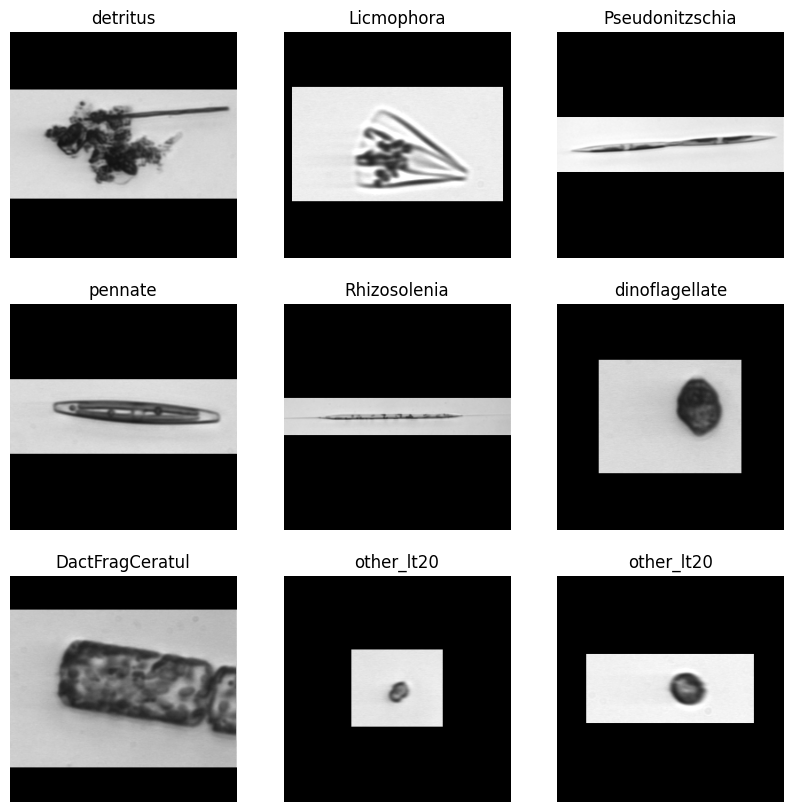

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(train_ds.class_names[tf.argmax(labels[i])])
        plt.axis("off")

2024-04-16 11:55:17.319885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


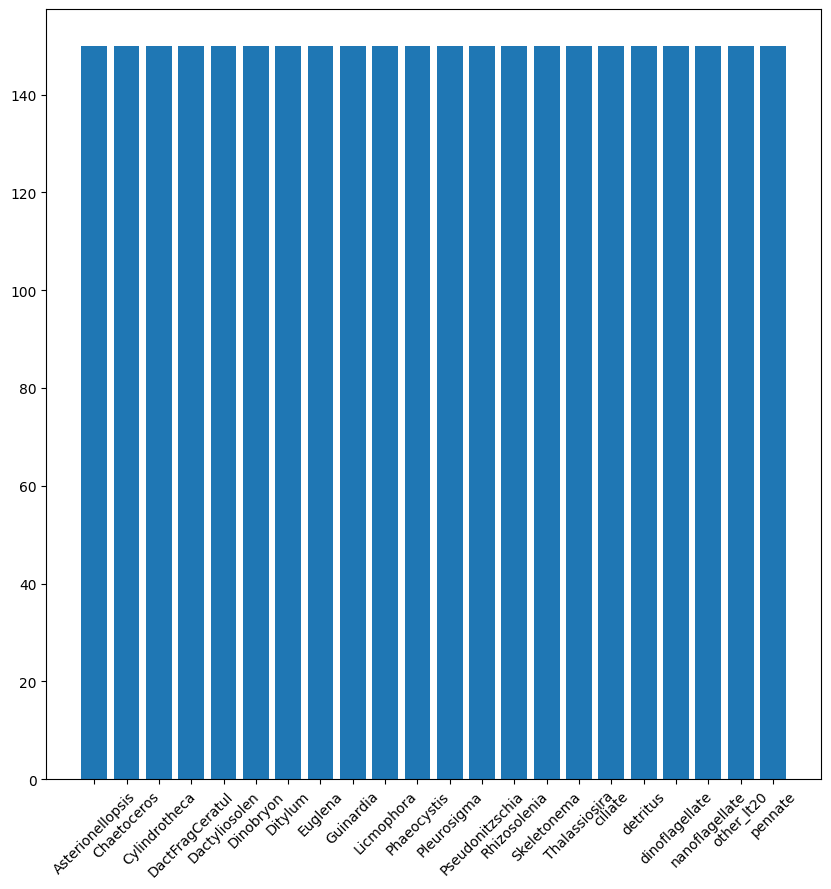

In [6]:
# Get distribution of labels as a bar chart. This demonstrates that the dataset is balanced.
class_labels = train_ds.class_names
label_counts = {}

for images, labels in train_ds:
    for label in labels:
        label_index = tf.argmax(label).numpy()
        class_name = class_labels[label_index]  # Get the class name
        if class_name in label_counts:
            label_counts[class_name] += 1
        else:
            label_counts[class_name] = 1
# plot the distribution
plt.figure(figsize=(10, 10))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(range(len(label_counts)), train_ds.class_names, rotation=45)
plt.show()

In [34]:
for images, labels in train_ds.take(1):
    print(images[1].shape)
    print(labels[1].shape)

(256, 256, 3)
(22,)


2024-04-15 15:01:13.486975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Start with the example "image classification from scratch" XCeption network, from keras [examples](https://keras.io/examples/vision/image_classification_from_scratch/)

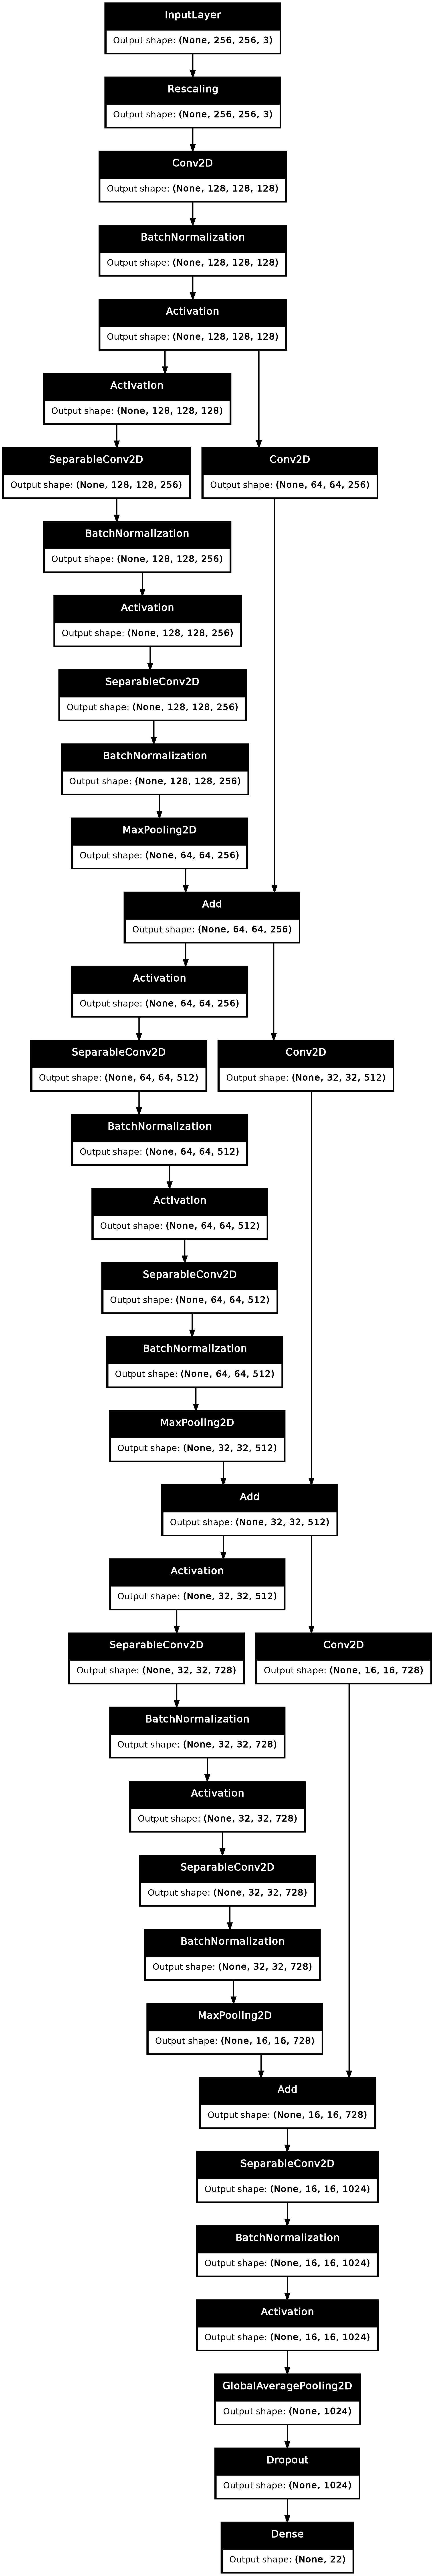

In [9]:
image_size = (256, 256)
batch_size = 32
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3,), num_classes=22)
keras.utils.plot_model(model, show_shapes=True)
#model.summary()

In [14]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("callbacks/save_at_{epoch}.keras", save_best_only=True),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 194ms/step - accuracy: 0.1326 - loss: 8.9659 - val_accuracy: 0.0837 - val_loss: 9.3151
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.0941 - loss: 8.3310 - val_accuracy: 0.1073 - val_loss: 8.7872
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.1241 - loss: 8.6076 - val_accuracy: 0.0773 - val_loss: 8.8113
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.1018 - loss: 8.9189 - val_accuracy: 0.0928 - val_loss: 7.6925
Epoch 5/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.0892 - loss: 8.6645 - val_accuracy: 0.0776 - val_loss: 8.7191
Epoch 6/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.0911 - loss: 8.8544 - val_accuracy: 0.0776 - val_loss: 7.9711
Epoch 7/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.0916 - loss: 8.2048 - val_accuracy: 0.0804 - val_loss: 7.7124
Epoch 8/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.0998 - loss: 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
[[ 4.8515635  5.473258  -2.7170966 -6.362389   2.151618  -6.3390126
  -3.991728  -2.8069503  3.4487438 -6.9775887 -6.6614633  4.006996
  -2.170115   1.2341144  3.7456114  5.7743244  4.554717   5.3702617
  -5.727601   2.1645622 -3.435177   3.8263905]]
Thalassiosira


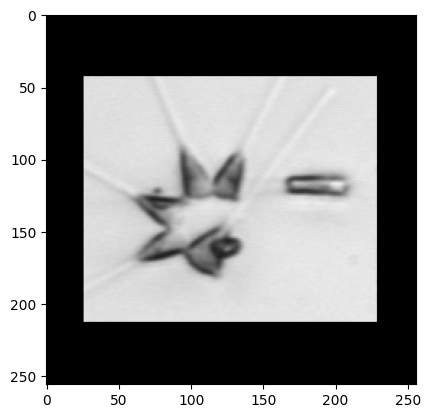

In [22]:
img = keras.utils.load_img("datasets/padded_testing/Asterionellopsis/2004_350_125245_1177.bmp", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
print(class_labels[tf.argmax(predictions[0]).numpy()])

In [15]:
import pickle
with open('experiments/history.pkl', 'wb') as f:
    pickle.dump(history, f)
with open('experiments/history.pkl', 'rb') as f:
    history = pickle.load(f)

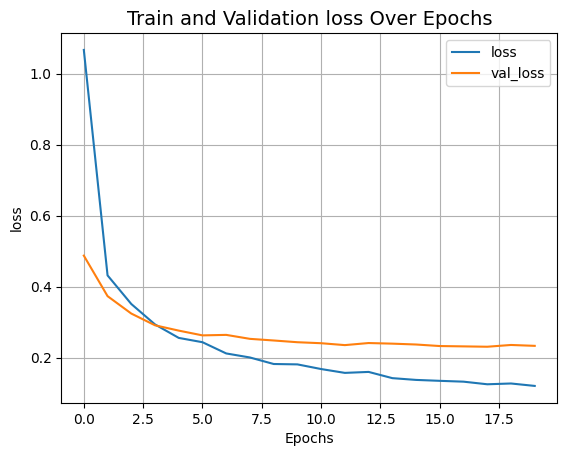

In [29]:

def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()
plot_history('loss')


In [26]:
from keras.applications.efficientnet import EfficientNetB7

base_model = EfficientNetB7(
    weights='imagenet',
    input_shape=image_size + (3,),
    include_top=False
)
base_model.trainable = False
inputs = keras.Input(shape=(256, 256, 3))

x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(22)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 8, 8, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │        56,342 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,154,029 (244.73 MB)

 Trainable params: 56,342 (220.09 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [27]:
history = model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=val_ds)


Epoch 1/20


2024-04-16 13:02:17.839791: W external/local_xla/xla/service/gpu/triton_autotuner.cc:660] Compiling 37 configs for 2 fusions on a single thread.
I0000 00:00:1713286939.489293 1145586 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_41234', 88 bytes spill stores, 88 bytes spill loads

I0000 00:00:1713286939.921204 1145586 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_41234', 420 bytes spill stores, 420 bytes spill loads



103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - categorical_accuracy: 0.6044 - loss: 1.6984

2024-04-16 13:04:01.927841: W external/local_xla/xla/service/gpu/triton_autotuner.cc:660] Compiling 35 configs for 2 fusions on a single thread.
I0000 00:00:1713287045.103042 1145586 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_41234', 116 bytes spill stores, 116 bytes spill loads



104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - categorical_accuracy: 0.6059 - loss: 1.6923

2024-04-16 13:04:53.809156: W external/local_xla/xla/service/gpu/triton_autotuner.cc:656] Compiling 18 configs for triton_gemm_dot.6733 on a single thread.
I0000 00:00:1713287095.236385 1145586 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6733', 116 bytes spill stores, 116 bytes spill loads



104/104 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - categorical_accuracy: 0.6073 - loss: 1.6864 - val_categorical_accuracy: 0.8757 - val_loss: 0.4872
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - categorical_accuracy: 0.8845 - loss: 0.4458 - val_categorical_accuracy: 0.8972 - val_loss: 0.3730
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - categorical_accuracy: 0.9090 - loss: 0.3500 - val_categorical_accuracy: 0.9048 - val_loss: 0.3239
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - categorical_accuracy: 0.9155 - loss: 0.2972 - val_categorical_accuracy: 0.9166 - val_loss: 0.2908
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - categorical_accuracy: 0.9276 - loss: 0.2566 - val_categorical_accuracy: 0.9196 - val_loss: 0.2758
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - categorical_accuracy: 0.9306 - loss: 0.2525 - val_categorical_accuracy: 0.9251 - val_loss: 0.2624
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - categorical_accuracy: 0.93

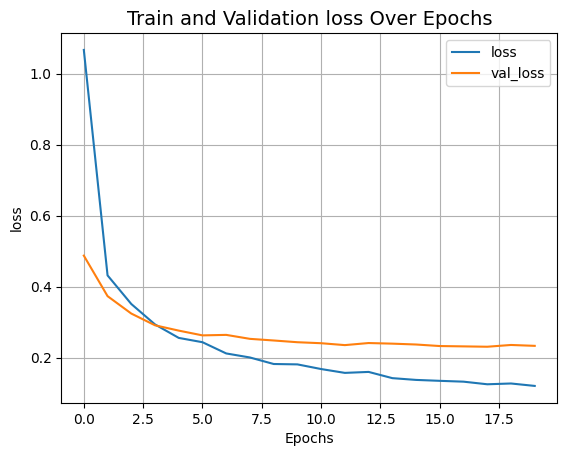

In [30]:
plot_history('loss')

In [ ]:
# Augment the train_ds dataset
